In [ ]:
# ==============================================================================
#
# BIRD SPECIES IDENTIFICATION - COLAB NOTEBOOK (FOR SEPARATE ZIP FILES)
#
# This notebook is adapted for the standard CUB-200-2011 dataset provided
# as two separate zip files: 'cub_200_2011.zip' and 'segments.zip'.
#
# ==============================================================================

import os
import tarfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# --- Scikit-learn Imports ---
from sklearn.metrics import accuracy_score

# Classical ML Models from the paper
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# ==================================
# 1. SETUP AND CONFIGURATION
# ==================================
print("✅ Step 1: Setting up configuration...")

# --- ACTION REQUIRED: UPDATE THIS FILE PATH ---

# 📌 STEPS TO FIND AND UPDATE YOUR FILE PATH:
#    1. Upload your 'CUB_200_2011.tgz' file to your Google Drive.
#    2. In your Colab notebook, click the "Files" icon on the left sidebar.
#    3. Click the "Mount Drive" button (looks like a folder with the Drive logo).
#    4. Navigate through the new 'drive/MyDrive/' folder to find your uploaded .tgz file.
#    5. Right-click on 'CUB_200_2011.tgz' and select "Copy path".
#    6. Paste the copied path into the CUB_TGZ_PATH variable below, replacing the placeholder.

CUB_TGZ_PATH = '/content/drive/MyDrive/dataset ML/CUB_200_2011.tgz' # <-- PASTE YOUR PATH HERE

# -----------------------------------------------

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- MODIFIED SECTION FOR .tgz EXTRACTION ---
# Un-tar the main dataset
print(f"Extracting dataset from {CUB_TGZ_PATH}...")
# We open the file with "r:gz" mode, which reads a gzipped tar file.
with tarfile.open(CUB_TGZ_PATH, "r:gz") as tar_ref:
    tar_ref.extractall(path='/content')
# --------------------------------------------

# Define the base directory for the CUB dataset files
CUB_DIR = '/content/CUB_200_2011/' # The extracted folder name
IMAGE_DIR = os.path.join(CUB_DIR, 'images')
print(f"Dataset extracted. Main directory set to: {CUB_DIR}")

# --- Model and Training Parameters ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 10
RANDOM_STATE = 42

✅ Step 1: Setting up configuration...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting dataset from /content/drive/MyDrive/dataset ML/CUB_200_2011.tgz...


/tmp/ipython-input-2366351359.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(path='/content')


Dataset extracted. Main directory set to: /content/CUB_200_2011/
Using device: cuda


In [ ]:
# ==================================
# 2. DATA PREPARATION
# ==================================
print("\n✅ Step 2: Preparing data using official dataset files...")

# Load metadata from the text files
images_df = pd.read_csv(os.path.join(CUB_DIR, 'images.txt'), sep=' ', names=['img_id', 'filepath'])
labels_df = pd.read_csv(os.path.join(CUB_DIR, 'image_class_labels.txt'), sep=' ', names=['img_id', 'class_id'])
split_df = pd.read_csv(os.path.join(CUB_DIR, 'train_test_split.txt'), sep=' ', names=['img_id', 'is_training_img'])

# Merge dataframes
data_df = images_df.merge(labels_df, on='img_id').merge(split_df, on='img_id')
data_df['class_id'] = data_df['class_id'] - 1 # Adjust class_id to be 0-indexed

# Separate into training and testing sets
train_df = data_df[data_df['is_training_img'] == 1]
test_df = data_df[data_df['is_training_img'] == 0]

X_train_paths = [os.path.join(IMAGE_DIR, fp) for fp in train_df['filepath']]
X_test_paths = [os.path.join(IMAGE_DIR, fp) for fp in test_df['filepath']]
y_train = train_df['class_id'].values
y_test = test_df['class_id'].values

num_classes = len(data_df['class_id'].unique())
print(f"Found {len(data_df)} total images belonging to {num_classes} classes.")
print(f"Using official split: {len(X_train_paths)} training samples, {len(X_test_paths)} testing samples.")

# PyTorch Custom Dataset
class BirdDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




✅ Step 2: Preparing data using official dataset files...
Found 11788 total images belonging to 200 classes.
Using official split: 5994 training samples, 5794 testing samples.


In [ ]:
# ========================================================
# 3. FEATURE EXTRACTION FOR CLASSICAL MODELS
# ========================================================
print("\n✅ Step 3: Extracting features using a pre-trained CNN...")

feature_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(DEVICE)
feature_extractor.eval()

def extract_features(dataset_paths, transform):
    dataset = BirdDataset(dataset_paths, labels=np.zeros(len(dataset_paths)), transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    all_features = []
    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Extracting Features"):
            inputs = inputs.to(DEVICE)
            features = feature_extractor(inputs)
            all_features.append(features.cpu().numpy())
    return np.concatenate(all_features)

X_train_features = extract_features(X_train_paths, data_transforms['test'])
X_test_features = extract_features(X_test_paths, data_transforms['test'])

print(f"Shape of training features: {X_train_features.shape}")
print(f"Shape of testing features: {X_test_features.shape}")


✅ Step 3: Extracting features using a pre-trained CNN...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
Extracting Features: 100%|██████████| 182/182 [00:49<00:00,  3.70it/s]

Shape of training features: (5994, 2048)
Shape of testing features: (5794, 2048)


In [ ]:
# ========================================================
# 4. TRAINING THE 7 CLASSICAL MODELS FROM THE PAPER
# ========================================================
print("\n✅ Step 4: Training the 7 classical ML models from the paper...")

models_to_train = {
    "1. Naive Bayes": GaussianNB(),
    "2. K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "3. Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "4. Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "5. Linear Discriminant Analysis (LDA)": LinearDiscriminantAnalysis(),
    "6. Support Vector Machine (SVM)": SVC(kernel='rbf', random_state=RANDOM_STATE),
    "7. Logistic Regression (One-vs-Rest)": LogisticRegression(multi_class='ovr', solver='liblinear', random_state=RANDOM_STATE, max_iter=1000)
}
results = {}

for name, model in models_to_train.items():
    print(f"--- Training {name} ---")
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Testing Accuracy for {name}: {accuracy:.4f}")




✅ Step 4: Training the 7 classical ML models from the paper...
--- Training 1. Naive Bayes ---
Testing Accuracy for 1. Naive Bayes: 0.6151
--- Training 2. K-Nearest Neighbors (KNN) ---
Testing Accuracy for 2. K-Nearest Neighbors (KNN): 0.4922
--- Training 3. Decision Tree ---
Testing Accuracy for 3. Decision Tree: 0.1961
--- Training 4. Random Forest ---
Testing Accuracy for 4. Random Forest: 0.5204
--- Training 5. Linear Discriminant Analysis (LDA) ---
Testing Accuracy for 5. Linear Discriminant Analysis (LDA): 0.6969
--- Training 6. Support Vector Machine (SVM) ---
Testing Accuracy for 6. Support Vector Machine (SVM): 0.6628
--- Training 7. Logistic Regression (One-vs-Rest) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Testing Accuracy for 7. Logistic Regression (One-vs-Rest): 0.6631


In [ ]:
# ========================================================
# 5. BONUS: TRAINING A MODERN CONVOLUTIONAL NEURAL NETWORK
# ========================================================
print("\n✅ Step 5: Training a modern CNN for potentially better results...")

train_dataset = BirdDataset(X_train_paths, y_train, transform=data_transforms['train'])
test_dataset = BirdDataset(X_test_paths, y_test, transform=data_transforms['test'])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, num_classes)
cnn_model = cnn_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

for epoch in range(NUM_EPOCHS_CNN):
    cnn_model.train()
    running_loss = 0.0
    for inputs, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_CNN}"):
        inputs, labels_batch = inputs.to(DEVICE), labels_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

print("Evaluating the CNN model...")
cnn_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels_batch in tqdm(test_loader, desc="Evaluating CNN"):
        inputs, labels_batch = inputs.to(DEVICE), labels_batch.to(DEVICE)
        outputs = cnn_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

cnn_accuracy = accuracy_score(all_labels, all_preds)
results["8. Fine-tuned CNN (ResNet50)"] = cnn_accuracy
print(f"Testing Accuracy for CNN: {cnn_accuracy:.4f}")


✅ Step 5: Training a modern CNN for potentially better results...


Epoch 1/10: 100%|██████████| 188/188 [01:27<00:00,  2.16it/s]


Epoch 1 Loss: 5.3975


Epoch 2/10: 100%|██████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 2 Loss: 5.2229


Epoch 3/10: 100%|██████████| 188/188 [01:25<00:00,  2.19it/s]


Epoch 3 Loss: 5.0296


Epoch 4/10: 100%|██████████| 188/188 [01:25<00:00,  2.19it/s]


Epoch 4 Loss: 4.8536


Epoch 5/10: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 5 Loss: 4.6724


Epoch 6/10: 100%|██████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch 6 Loss: 4.4957


Epoch 7/10: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]


Epoch 7 Loss: 4.3175


Epoch 8/10: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 8 Loss: 4.2220


Epoch 9/10: 100%|██████████| 188/188 [01:25<00:00,  2.19it/s]


Epoch 9 Loss: 4.0868


Epoch 10/10: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 10 Loss: 3.9277
Evaluating the CNN model...


Evaluating CNN: 100%|██████████| 182/182 [00:48<00:00,  3.78it/s]

Testing Accuracy for CNN: 0.1329




      FINAL MODEL ACCURACIES      

                                Model  Testing Accuracy
5. Linear Discriminant Analysis (LDA)          0.696928
 7. Logistic Regression (One-vs-Rest)          0.663100
      6. Support Vector Machine (SVM)          0.662755
                       1. Naive Bayes          0.615119
                     4. Random Forest          0.520366
         2. K-Nearest Neighbors (KNN)          0.492233
                     3. Decision Tree          0.196065
         8. Fine-tuned CNN (ResNet50)          0.132896


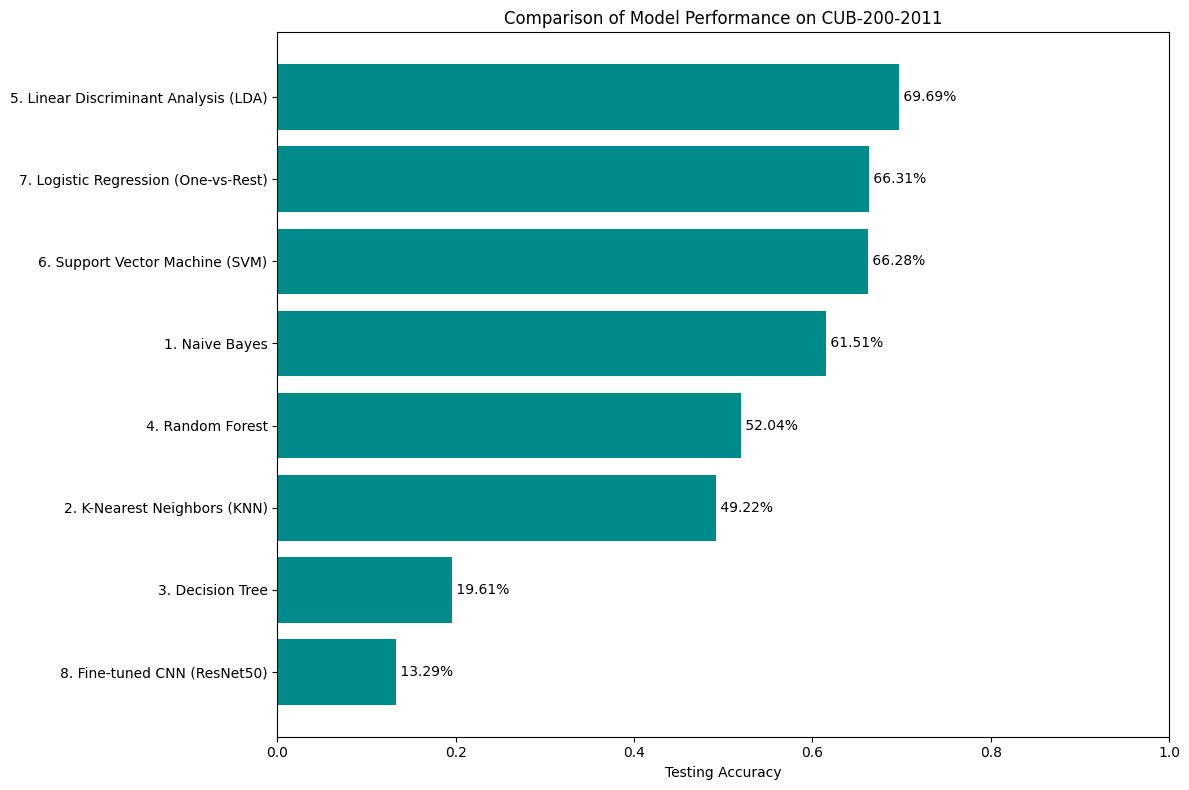

In [ ]:
# ========================================================
# 6. FINAL RESULTS
# ========================================================
print("\n\n====================================")
print("      FINAL MODEL ACCURACIES      ")
print("====================================\n")

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Testing Accuracy'])
results_df = results_df.sort_values(by='Testing Accuracy', ascending=False)
print(results_df.to_string(index=False))

plt.figure(figsize=(12, 8))
bars = plt.barh(results_df['Model'], results_df['Testing Accuracy'], color='darkcyan')
plt.xlabel('Testing Accuracy')
plt.title('Comparison of Model Performance on CUB-200-2011')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f' {bar.get_width():.2%}', va='center', ha='left')
plt.tight_layout()
plt.show()